**authors**: David M. Knigge, David R. Wessels

# Equivariant Neural Fields Explainer
## Fitting and classifying MNIST with ENFs from scratch
In this notebook, we will explain the Equivariant Neural Field (ENF) architecture, and its use as a continuous signal representation. This notebook
mostly focuses on the practical aspects of implementing an ENF and makes some slight simplifications in implementation, for a more theoretical and complete explanation, please refer to the original
[paper](https://arxiv.org/abs/2406.05753) or its accompanying [blogpost]().

This notebook is divided into the following sections:
1. [Bi-invariant](#bi-invariant) Constructing the bi-invariant $a(x, p)$ for translations $\mathbb{R}^n$.
2. [Equivariant Cross Attention](#equivariant-cross-attention) Defining the equivariant cross attention operation.
3. [ENF architecture](#enf-architecture) Constructing the ENF architecture.
4. [Fitting MNIST using MetaSGD](#fitting-mnist-using-metasgd) Training the ENF using Meta-SGD on MNIST.
5. [Downstream classification on ENF latents](#downstream-classification) Performing downstream classification on ENF latents for MNIST.

## Bi-invariant
Equivariance in the ENF architecture $f_\theta$, for given group element $g$, signal location $x$ and latent $z=\{(p, \mathbf{a})\}_{i=1}^N$ defined as: $$\mathcal{L}_g f_\theta(x, z)=f_\theta(g^{-1}x, z) =f_\theta(x, gz).$$ is achieved by parameterizing core attention operation in terms of a bi-invariant function $a(x, p)$. In this section, we will construct the bi-invariant function $a(x, p)$ for translations $\mathbb{R}^2$. In [this repo](https://github.com/david-knigge/enf-min-jax), other invariants may be found under `enf/bi_invariants/*.py`.

We first implement a base-class, which defines the interface for all bi-invariants. The base-class contains the following properties: 
- `dim`: The dimension of the bi-invariant, i.e. the size of the output of the bi-invariant.
- `num_x_pos_dims`: The number of spatial dimensions of the input signal $x$.
- `num_x_ori_dims`: The number of orientation dimensions of the input signal $x$.
- `num_z_pos_dims`: The number of spatial dimensions of the latent $p$.
- `num_z_ori_dims`: The number of orientation dimensions of the latent $p$.

Furthermore, the baseclass defines a gaussian window function, which is used in calculation of the attention weights in the ENF architecture. The gaussian window function is defined as: $$\mathcal{G}(x, p, \sigma) = -\frac{1}{\sigma^2}||x - p_\text{pos}||^2,$$ with $p_\text{pos}$ the positional coordinates of the latent. You can simply this of this as placing a gaussian window at the location of the latent.

For 2D translations, we implement the `RnBiInvariant` class, which inherits from the `BaseBiInvariant` base-class. The `RnBiInvariant` class implements the following methods:

In [1]:
import jax
import jax.numpy as jnp


class BaseBiInvariant:
    """Base class for bi-invariants. Bi-invariants are functions that are invariant to the simultaneous action of a
    group on the input and latent poses.

    The base class provides a common interface for all bi-invariants. Subclasses must implement the __call__ method.

    The following properties must be set in the subclass:
    - dim: The dimensionality of the bi-invariant.
    - num_x_pos_dims: The number of spatial dimensions for the input coordinates.
    - num_x_ori_dims: The number of orientation dimensions for the input orientations.
    - num_z_pos_dims: The number of spatial dimensions for the latent coordinates.
    - num_z_ori_dims: The number of orientation dimensions for the latent orientations.
    """

    def __init__(self):
        super().__init__()

        # Every invariant has a dimensionality.
        self.dim = None

        # Every invariant can have a different number of dimensions for the input coordinate and latent poses.
        self.num_x_pos_dims = None
        self.num_x_ori_dims = None
        self.num_z_pos_dims = None
        self.num_z_ori_dims = None

    def calculate_gaussian_window(self, x, p, sigma):
        """ Calculate the gaussian window in $R^n$.

        Args:
            x (jax.numpy.ndarray): The pose of the input coordinates. Shape (batch_size, num_coords, num_x_pos_dims).
            p (jax.numpy.ndarray): The pose of the latent points. Shape (batch_size, num_latents, num_z_pos_dims).
            sigma (jax.numpy.ndarray): The standard deviation of the gaussian window. Shape (batch_size, num_latents).

        Returns:
            jax.numpy.ndarray: The gaussian window value. Shape (batch_size, num_coords, num_latents, 1).
        """
        # Extract the positional coordinates.
        p_pos = p[:, :, :self.num_z_pos_dims]
        x_pos = x[:, :, :self.num_x_pos_dims]

        # Calculate squared norm distance between x and p
        norm_rel_dists = jnp.sum((p_pos[:, None, :, :] - x_pos[:, :, None, :]) ** 2, axis=-1, keepdims=True)

        # Calculate the gaussian window
        return - (1 / sigma[:, None, :] ** 2) * norm_rel_dists

    def __call__(self, x, p):
        """Calculate the bi-invariant between the input coordinates and the latent poses.

        Args:
            x (jax.numpy.ndarray): The pose of the input coordinates. Shape (batch_size, num_coords, num_x_pos_dims).
            p (jax.numpy.ndarray): The pose of the latent points. Shape (batch_size, num_latents, num_z_pos_dims).

        Returns:
            jax.numpy.ndarray: The bi-invariant between the input coordinates and the latent poses.
                Shape (batch_size, num_coords, num_latents, dim).
        """
        raise NotImplementedError("Subclasses must implement this method")

The `RnBiInvariant` then populates the properties of the base-class, and implements the `__call__` method. The `__call__` method calculates the bi-invariant between the input coordinates and the latent poses, assuming the input coordinates and latent poses are both defined over $R^n$. The bi-invariant is calculated as the squared norm distance between the input coordinates and the latent poses. The `RnBiInvariant` class is defined as follows:

In [2]:
class RnBiInvariant(BaseBiInvariant):

    def __init__(self, num_dims: int):
        """ Calculate the relative position between two sets of coordinates in N dimensions.

        Args:
            num_dims (int): The dimensionality of the coordinates, corresponds to the dimensionality of the translation
                group.
        """
        super().__init__()

        # Set the dimensionality of the invariant.
        self.dim = num_dims

        # This invariant is calculated based on two sets of positional coordinates, it doesn't depend on
        # the orientation.
        self.num_x_pos_dims = num_dims
        self.num_x_ori_dims = 0
        self.num_z_pos_dims = num_dims
        self.num_z_ori_dims = 0

    def __call__(self, x, p):
        """
        Calculate the relative position between two sets of coordinates in N dimensions.

        Args:
            x (jax.numpy.ndarray): The pose of the input coordinates. Shape (batch_size, num_coords, num_x_pos_dims).
            p (jax.numpy.ndarray): The pose of the latent points. Shape (batch_size, num_latents, num_z_pos_dims).

        Returns:
            jax.numpy.ndarray: The relative position between x and p.
                Shape (batch_size, num_coords, num_latents, num_x_pos_dims).
        """
        return x[:, :, None, :self.num_x_pos_dims] - p[:, None, :, :self.num_z_pos_dims]


To show what this bi-invariant calculates in practice, we will create a simple example. We define a set of input coordinates on a 2D grid, and a set of some randomly sampled latent coordinates. We then calculate the bi-invariant between input coordinates and latent coordinates, and visualize the two channels of the resulting bi-invariant. The first channel corresponds to the relative x-coordinate, and the second channel corresponds to the relative y-coordinate.

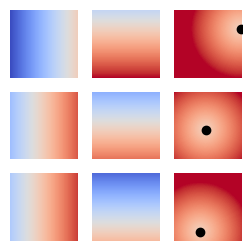

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [3, 3]

# Set grid resolution number of steps, and number of latents.
num_steps = 100
num_latents = 3

# Create a random key
key = jax.random.PRNGKey(33)

# Create a batch (with 1 sample) of 100 input coordinates on a 2D grid.
x = jnp.stack(jnp.meshgrid(jnp.linspace(-1, 1, num_steps), jnp.linspace(-1, 1, num_steps)), axis=-1).reshape(-1, 2)[None, ...] # (1, 100, 2)

# Create a batch (with 1 sample) of 5 latent coordinates.
p = jax.random.uniform(key, (1, num_latents, 2)) * 2 - 1 # (1, num_latents, 2)

# Create the bi-invariant for 2D translations.
bi_invariant = RnBiInvariant(num_dims=2)

# Calculate the bi-invariant between the input coordinates and the latent coordinates.
bi_invariant_values = bi_invariant(x, p) # (1, 100, num_latents, 2)

# Visualize the bi-invariants.
fig, axs = plt.subplots(num_latents, 3, figsize=(3, num_latents))
vmin, vmax = bi_invariant_values.min(), bi_invariant_values.max()
for i, ax in enumerate(axs):
    for j, a in enumerate(ax[:2]):
        a.imshow(bi_invariant_values[0, :, i, j].reshape(num_steps, num_steps), cmap='coolwarm', vmin=vmin, vmax=vmax)
        a.axis('off')
    a = ax[2]
    # Plot the latent position, and the norm of the bi-invariant. Position is [-1, 1], we need to map it to [0, 10].
    p_norm = (p + 1) / 2 * num_steps
    a.scatter(p_norm[0, i, 0], p_norm[0, i, 1], color='black', label='Latent')
    a.imshow(jnp.linalg.norm(bi_invariant_values[0, :, i, :], axis=-1).reshape(num_steps, num_steps), cmap='coolwarm', vmin=vmin, vmax=vmax)
    a.axis('off')
plt.show()

The rows are different latents, the columns are (left) the first channel of the bi-invariant, (middle) the second channel of the bi-invariant and (right) the norm of the bi-invariant.

The two channels correspond to the relative x and y coordinates between the input coordinates and the latent coordinates. The third column shows the latent coordinates as black dots, and the norm of the bi-invariant for each latent. Checks out! Next, we'll use this bi-invariant to implement the equivariant cross-attention operation.

## Equivariant Cross Attention
The operation that forms the backbone to the ENF architecture is the equivariant cross-attention between latents $\{(p_i, \mathbf{a}_i \}_{i=1}^N$ and input coordinates $x$ as a function of a bi-invariant $a(x, p)$. Here, we implement a slightly simplified variant of the `EquivariantCrossAttention` module found in [this repo](https://github.com/david-knigge/enf-min-jax) under `enf/enf.py`, that doesn't apply conditioning from the bi-invariant to the value transform for a latent (more details below).

We use `flax` to define our modules.

We start off defining an `RFFEmbedding` module. This module will embed bi-invariants into a higher dimensional space before the query transform is applied. In neural fields literature, such embeddings are applied to alleviate oversmoothing of the input due to a phenomenon of neural networks known as spectral bias. See the excellent paper by [Tancik et al. (2020)](https://arxiv.org/abs/2006.10739) if you would like to gain a deeper understanding for why this is necessary. Very simply put, you could think of this embedding module as separating coordinates that are close in the output of our bi-invariant such that the neural field is better able to fit high frequencies to them, i.e. this enables learning sharp transitions in the input signal. Here, the `std` parameter controls the output frequency of the embedding. Typically, this is tuned to the type of signal/dataset you are fitting.

In [4]:
import flax.linen as nn

class RFFEmbedding(nn.Module):
    embedding_dim: int
    learnable_coefficients: bool
    std: float

    def setup(self):
        # Make sure we have an even number of hidden features.
        assert (
            not self.embedding_dim % 2.0
        ), "For the Fourier Features hidden_dim should be even to calculate them correctly."

        # Store pi
        self.pi = 2 * jnp.pi

        # Embedding layer
        self.coefficients = nn.Dense(self.embedding_dim // 2, use_bias=False, kernel_init=nn.initializers.normal(stddev=1))
        self.concat = lambda x: jnp.concatenate([jnp.sin(x), jnp.cos(x)], axis=-1)

        if self.learnable_coefficients:
            self.parsed_coefficients = lambda x: self.coefficients(self.pi * x)
        else:
            self.parsed_coefficients = lambda x: jax.lax.stop_gradient(self.coefficients(self.pi * x))

    def __call__(self, x):
        return self.concat(self.std * self.parsed_coefficients(x))

To show what exactly this module does, let's again create a grid of 2D coordinates and push them through the embedding.

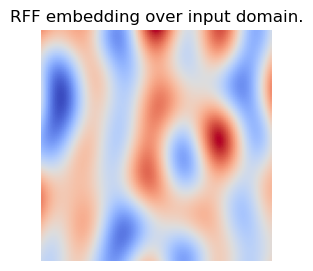

In [5]:
# Create an RFF embedding with dim 32
rff = RFFEmbedding(embedding_dim=32, learnable_coefficients=False, std=1.0)
rff_params = rff.init(key, x)

# Embed the input coordinates
x_emb = rff.apply(rff_params, x)

# Apply a random map 32 -> 1 for visualization.
W = jax.random.normal(key, (32, 1))
x_emb = x_emb @ W

# Visualize
x_emb = (x_emb - x_emb.min()) / (x_emb.max() - x_emb.min())
plt.imshow(x_emb[0].reshape(num_steps, num_steps, 1), vmin=x_emb.min(), vmax=x_emb.max(), cmap='coolwarm')
plt.axis('off')
plt.title("RFF embedding over input domain.")
plt.show()

As we can see, the purpose of the RFF embedding is to introduce higher frequencies over the input domain. You can use the ENF attention module without any embedding, but you'll see it doesn't perform as well.

Next, we define the equivariant cross attention operator. Following Sec. 3.3 in the original paper, we have:

$$
\operatorname{equivariant\_cross\_attn}(x; z) = \mathbf{W}_o\sum_{i=1}^N att(x, z_:) \mathbf{v}(\mathbf{c}_i) \;\;\;\;\;\;\; \text{with} \;\;\;\;\;\;\; att(x, z_:) = \underset{i}{\operatorname{softmax}} \left( \;\; \frac{\mathbf{q}(\mathbf{a}(x,p_i))^T \mathbf{k}(\mathbf{c}_i)}{\sqrt{d_k}} \right) \,
$$

where we let

\begin{align}
\mathbf{a}(x, p_i) &:= \phi(x - p_i) \\
\mathbf{q}(\mathbf{a}(p_i^{-1}x)) &:= \mathbf{W}_q \mathbf{a}(x,p_i) \\
\mathbf{k}(\mathbf{c}_i)&:= \mathbf{W}_k \mathbf{c}_i\\
\mathbf{v}(\mathbf{c}_i) &:= \mathbf{W}_v \mathbf{c}_i
\end{align}

In implementation, we have $m$ attention heads, which are mapped back to a vector of size `hidden_dim` by a weight $\mathbf{W}_o$.

**Note:**
Compared to the `EquivariantCrossAttention` module found in `enf/enf.py`, as a simplification in this piece of code we **do not** do any conditioning of $v$ based on $a(x, p)$, i.e. here we have $\mathbf{v}(\mathbf{c}_i)$ instead of $\mathbf{v}(\mathbf{a}(x,p_i), \mathbf{c}_i)$ which somewhat limits the reconstruction performance of this particular implementation.

Essentially you can think of this conditioning from $a(x, p)$ to $\mathbf{v}$ as a way of getting *relative-position specific* values for a latent $z_i$. In other words, this conditioning allows for the same latent $z_i$ to yield different values of $\mathbf{v}$ for different values of $x_i$. Works better, but the code is a bit more complex, see `enf/enf.py`. 

In [6]:
class EquivariantCrossAttention(nn.Module):
    num_hidden: int
    num_heads: int
    bi_invariant: BaseBiInvariant
    embedding_freq_multiplier: tuple

    def setup(self):
        # Bi-invariant embedding for the query transforms.
        self.emb_q = RFFEmbedding(embedding_dim=self.num_hidden, learnable_coefficients=False, std=self.embedding_freq_multiplier)

        # Bi-invariant embedding -> query
        self.emb_to_q = nn.Dense(self.num_heads * self.num_hidden)

        # Context vector -> key, value
        self.c_to_kv = nn.Dense(2 * self.num_heads * self.num_hidden)

        # Output projection
        self.out_proj = nn.Dense(self.num_heads * self.num_hidden)

        # Set the scale factor for the attention weights.
        self.scale = 1.0 / (self.num_hidden ** 0.5)

    def __call__(self, x, p, c, g):
        """ Apply equivariant cross attention.

        Args:
            x (jax.numpy.ndarray): The input coordinates. Shape (batch_size, num_coords, coord_dim).
            p (jax.numpy.ndarray): The latent poses. Shape (batch_size, num_latents, coord_dim).
            c (jax.numpy.ndarray): The latent context vectors. Shape (batch_size, num_latents, latent_dim).
            g (jax.numpy.ndarray): The window size for the gaussian window. Shape (batch_size, num_latents, 1).
        """
        # Get bi-invariants of input coordinates wrt latent coordinates. Depending on the bi-invariant, the last dim of the
        # bi-invariants tensor will be different, but the first dims should look like:
        #   -> [batch_size, num_coords, num_latents, ...]
        bi_inv = self.bi_invariant(x, p)

        # Calculate the query, key and value.
        q = self.emb_to_q(self.emb_q(bi_inv))
        k, v = jnp.split(self.c_to_kv(c), 2, axis=-1)

        # Reshape the query, key and value to separate the heads.
        q = q.reshape(q.shape[:-1] + (self.num_heads, self.num_hidden))
        k = k.reshape(k.shape[:-1] + (self.num_heads, self.num_hidden))
        v = v.reshape(v.shape[:-1] + (self.num_heads, self.num_hidden))
        
        # For every input coordinate, calculate the attention weights for every latent,
        # broadcasting the keys over the input coordinates.
        # q: [batch, num_coords, num_latents, num_heads, hidden_dim]
        # k: [batch, 1, num_latents, hidden_dim]
        #   -> [batch, num_coords, num_latents, num_heads]
        att = (q * k[:, None, ...]).sum(axis=-1) * self.scale

        # Calculate and apply the gaussian window
        att = att + self.bi_invariant.calculate_gaussian_window(x, p, sigma=g)
        
        # Take softmax over the num_latents dim
        att = jax.nn.softmax(att, axis=2)

        # Apply attention to the values, broadcasting the values over the input coordinates.
        y = (att[..., None] * v[:, None, ...]).sum(axis=2)  # 'bczh,bczhd->bchd'

        # Reshape y to concatenate the heads.
        y = y.reshape(*y.shape[:2], self.num_heads * self.num_hidden)

        # output projection
        y = self.out_proj(y)
        return y

Let's give it a spin.

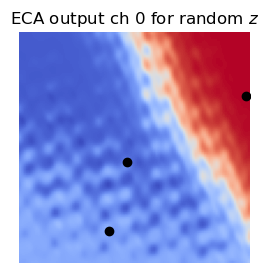

In [7]:
eca = EquivariantCrossAttention(
    num_hidden=16,
    num_heads=2,
    bi_invariant=bi_invariant,
    embedding_freq_multiplier=3.
)

# Create a random context vector for each latent
c = jax.random.uniform(key, (1, num_latents, 16)) * 2 - 1 # (1, num_latents, 2)

# Create a gaussian window parameter for each latent
g = jnp.ones((1, num_latents, 1)) * 0.5

eca_params = eca.init(key, x, p, c, g)

# Let's apply the model and visualize the first channel of the output,
# also plotting the latents
out = eca.apply(eca_params, x, p, c, g)
plt.imshow(out[0, :, 0].reshape(num_steps, num_steps), cmap='coolwarm')
p_norm = (p + 1) / 2 * num_steps
plt.scatter(p_norm[0, :, 0], p_norm[0, :, 1], color='black', label='Latent')
plt.axis('off')
plt.title(r"ECA output ch 0 for random $z$")
plt.show()

Alright, we are producing some output. Now we can put it all together in an ENF module.

## ENF Architecture

The ENF architecture we used in the paper is quite simple, taking inspiration from GPT-2's attention blocks. First, we need to map the context vectors $\mathbf{c}_i$ to the hidden dim in which we want to perform our attention operation. Below, we do this with the `latent_stem`. Next, we found applying LayerNorm to $\mathbf{c}_i$ before the attention operation usually increases learning stability. This operation is followed by the equivariant cross attention we defined above, which is itself followed by a FFN, and some output linear layers.

Let's reproduce it here. First, we define a pointwise feed-forward network.

In [8]:
class PointwiseFFN(nn.Module):
    """ Pointwise FFN with optional LayerNorm"""
    num_hidden: int
    num_out: int
    num_layers: int = 1
    norm: bool = True

    @nn.compact
    def __call__(self, x):
        for _ in range(self.num_layers):
            x = nn.Dense(self.num_hidden)(x)
            x = jax.nn.gelu(x)
            if self.norm:
                x = nn.LayerNorm()(x)
        x = nn.Dense(self.num_out)(x)
        return x

We'll use this in the ENF architecture we define below!

In [9]:
class EquivariantNeuralField(nn.Module):
    """ Equivariant cross attention network for the latent points, conditioned on the poses.

    Args:
        num_hidden (int): The number of hidden units.
        num_heads (int): The number of attention heads.
        num_out (int): The number of output coordinates.
        latent_dim (int): The dimensionality of the latent code.
        bi_invariant (BaseBiInvariant): The invariant to use for the attention operation.
        embedding_freq_multiplier (Union[float, float]): The frequency multiplier for the embedding.
    """

    num_hidden: int
    num_heads: int
    num_out: int
    bi_invariant: BaseBiInvariant
    embedding_freq_multiplier: float

    def setup(self):
        # Maps latent to hidden
        self.latent_stem = nn.Dense(self.num_hidden)

        # Cross attn block
        self.layer_norm_attn = nn.LayerNorm()
        self.attn = EquivariantCrossAttention(
            num_hidden=self.num_hidden,
            num_heads=self.num_heads,
            bi_invariant=self.bi_invariant,
            embedding_freq_multiplier=self.embedding_freq_multiplier
        )
        self.ffn_attn = PointwiseFFN(num_hidden=self.num_hidden, num_out=self.num_hidden)

        # Output FFN
        self.ffn_out = PointwiseFFN(num_hidden=self.num_hidden, num_out=self.num_out, num_layers=2, norm=False)

    def __call__(self, x, p, c, g):
        """ Sample from the model.

        Args:
            x (jnp.Array): The pose of the input points. Shape (batch_size, num_coords, 2).
            p (jnp.Array): The pose of the latent points. Shape (batch_size, num_latents, num_ori (1), 4).
            c (jnp.Arrays): The latent features. Shape (batch_size, num_latents, num_hidden).
            g (float or None): The window size for the gaussian window.
        """
        # Map code to latent space
        c = self.latent_stem(c)

        # Cross attention block, pre-norm on context vectors
        c = self.layer_norm_attn(c)
        f_hat = self.attn(x=x, p=p, c=c, g=g)
        f_hat = self.ffn_attn(f_hat)
        f_hat = jax.nn.gelu(f_hat)

        # Output layers
        return self.ffn_out(f_hat)

Cool, let's see if we get something out.

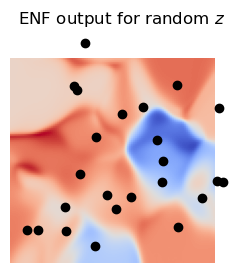

In [10]:
# We set these config parameters (also used later). For the taks we're performing
# we can get away with a small latent dim.
num_hidden = 32
num_heads = 2
num_out = 1
num_latents = 24
latent_dim = 16
freq_multiplier = 1

enf = EquivariantNeuralField(
    num_hidden=num_hidden,
    num_heads=num_heads,
    num_out=num_out,
    bi_invariant=bi_invariant,
    embedding_freq_multiplier=freq_multiplier
)

# Create a batch (with 1 sample) of 100 input coordinates on a 2D grid.
x = jnp.stack(jnp.meshgrid(jnp.linspace(-1, 1, num_steps), jnp.linspace(-1, 1, num_steps)), axis=-1).reshape(-1, 2)[None, ...] # (1, 100, 2)

# Create a batch (with 1 sample) of 5 latent coordinates.
p = jax.random.normal(key, (1, num_latents, 2)) * 0.5 # (1, num_latents, 2)

# Create a random context vector for each latent
c = jax.random.normal(key, (1, num_latents, latent_dim)) * 2 - 1 # (1, num_latents, 2)

# Create a gaussian window parameter for each latent, we make this quite small so 
# the locality clearly shows in the visualization
g = jnp.ones((1, num_latents, 1)) * 0.2

# Initialize the model
enf_params = enf.init(key, x, p, c, g)

# Apply it!
out = enf.apply(enf_params, x, p, c, g)

# A quick normalization for visualization purposes
out = (out - out.min()) / (out.max() - out.min())
plt.imshow(out.reshape(num_steps, num_steps, 1), cmap='coolwarm')
p_norm = (p + 1) / 2 * num_steps
plt.scatter(p_norm[0, :, 0], p_norm[0, :, 1], color='black', label='Latent')
plt.axis('off')
plt.title(r"ENF output for random $z$")
plt.show()

Interesting, as you can see we're getting some pretty strange patterns, but in the output we can clearly see transitions between the latents.

Now it's time to define our training loops and downstream tasks!

## Fitting MNIST using MetaSGD

We fit the weights of the ENF $\theta$ with meta-learning, essentially re-initializing the latents $z$ every outer-loop step and optimizing them for a limited (usually 3) number of steps in the inner loop. We follow [Functa](https://arxiv.org/abs/2201.12204) in using Meta-SGD to learn the learning rates used in this inner loop. In JAX, this procedure is quite simple. Let's implement it for fitting MNIST. Here we quickly create a dataloader that loads MNIST images as numpy arrays.

In [11]:
from typing import Union, Any, Sequence

import numpy as np
from torch.utils import data
import torchvision


def numpy_collate(batch: Union[np.ndarray, Sequence[Any], Any]):
    """
    This function acts as replacement to the standard PyTorch-tensor collate function in PyTorch DataLoader.

    Args:
        batch: Batch of data. Can be a numpy array, a list of numpy arrays, or nested lists of numpy arrays.

    Returns:
        Batch of data as (potential list or tuple of) numpy array(s).
    """
    if isinstance(batch, np.ndarray):
        return batch
    elif isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)


def get_dataloader():
    transform = torchvision.transforms.Compose([lambda x: np.array(x) / 255])
    train_dset = torchvision.datasets.MNIST(root='./data', train=1, transform=transform, download=1)
    test_dset = torchvision.datasets.MNIST(root='./data', train=0, transform=transform, download=1)

    train_loader = data.DataLoader(
        train_dset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        collate_fn=numpy_collate,
        persistent_workers=False,
        drop_last=True
    )

    test_loader = data.DataLoader(
        test_dset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        collate_fn=numpy_collate,
        persistent_workers=False,
        drop_last=True
    )

    return train_loader, test_loader

batch_size = 16
train_loader, test_loader = get_dataloader()

We define optimizers for $\theta$ and the inner learning rates for $c_i, p_i$. We use optax for optimization.

In [12]:
import optax

# Define optimizer for the ENF backbone
enf_optimizer = optax.adam(learning_rate=1e-4)
enf_opt_state = enf_optimizer.init(enf_params)

# Define optimizer for meta SGD, a single learning rate for the poses and separate learning rates for the channels
# of the context vectors.
meta_sgd_params = [1.0, jnp.ones(latent_dim) * 0.5]
meta_sgd_optimizer = optax.adam(learning_rate=1e-3)
meta_sgd_opt_state = meta_sgd_optimizer.init(meta_sgd_params)

We now define an outer loop that takes as input the model parameters $\theta$, the inner learning rates (also model parameters), input coordinates `x_i` and corresponding pixel values `y_i`. Note that for simplicity of implementation, we assume `x_i, y_i` are batches for MNIST images, i.e. `x_i` has shape `[batch_dim, 784, 2]` and `y_i` has shape `[batch_dim, 784, 1]`.

In [13]:
@jax.jit
def inner_loop(params, x_i, y_i, key):
    # Unpack params
    enf_params, meta_sgd_params = params

    # Initialize values for the poses, note that these depend on the bi-invariant, context and window
    p = jax.random.normal(key, (x_i.shape[0], num_latents, 2)) * 0.5 # poses
    c = jnp.ones((x_i.shape[0], num_latents, latent_dim))  # context vectors
    g = jnp.ones((x_i.shape[0], num_latents, 1)) * 2 / jnp.sqrt(num_latents)  # gaussian window parameter, set as function of the number of latents

    # Every inner loop step, we take the MSE between the output of the ENF
    # and the ground truth images. We then backprop to z and optimize!
    def mse_loss(z, x_i, y_i):
        out = enf.apply(enf_params, x_i, *z)
        return jnp.sum(jnp.mean((out - y_i) ** 2, axis=(1, 2)), axis=0)

    # Perform 3 inner steps
    for i in range(3):
        # Gradients of the inner loop wrt z
        loss, grads = jax.value_and_grad(mse_loss)((p, c, g), x_i, y_i)

        # Update the latents, scale gradients by number of points and number of latents
        p = p - meta_sgd_params[0] * grads[0]
        c = c - meta_sgd_params[1] * grads[1]

    # Return loss with resulting latents from last inner loop step
    return mse_loss((p, c, g), x_i, y_i), (p, c, g)

@jax.jit
def outer_step(x_i, y_i, enf_params, meta_sgd_params, enf_opt_state, meta_sgd_opt_state, key):
    # Perform inner loop optimization
    (loss, _), grads = jax.value_and_grad(inner_loop, has_aux=True)([enf_params, meta_sgd_params], x_i, y_i, key)

    # Update the ENF backbone
    enf_grads, enf_opt_state = enf_optimizer.update(grads[0], enf_opt_state)
    enf_params = optax.apply_updates(enf_params, enf_grads)

    # Update the meta SGD parameters
    meta_sgd_grads, meta_sgd_opt_state = meta_sgd_optimizer.update(grads[1], meta_sgd_opt_state)
    meta_sgd_params = optax.apply_updates(meta_sgd_params, meta_sgd_grads)

    # Sample new key
    new_key, key = jax.random.split(key)
    return loss, enf_params, meta_sgd_params, enf_opt_state, meta_sgd_opt_state, new_key

Now all that's left for fitting MNIST images is generating a set of coordinates that corresponds to a batch of MNIST images, and writing a training loop. Training takes a while, 10 epochs takes about 15 minutes on my 3090ti.

In [14]:
# We create a set of batched mesh-grids ranging from [-1, -1] to [1, 1].
x = jnp.stack(jnp.meshgrid(jnp.linspace(-1, 1, 28), jnp.linspace(-1, 1, 28)), axis=-1).reshape(-1, 2) # (1, 784, 2)
x_i = jnp.broadcast_to(x[None, ...], (batch_size, 784, 2)) # (batch_size, 784, 2)

# And the training loop.
for epoch in range(100):
    epoch_loss = []
    for i, batch in enumerate(train_loader):
        # Unpack batch, flatten img.
        img, _ = batch
        y_i = jnp.reshape(img, (batch_size, 784, 1))

        # Perform outer loop optimization
        loss, enf_params, meta_sgd_params, enf_opt_state, meta_sgd_opt_state, key = outer_step(
            x_i, y_i, enf_params, meta_sgd_params, enf_opt_state, meta_sgd_opt_state, key)

        epoch_loss.append(loss)
    if not epoch % 10:
        print(f"epoch {epoch} -- loss: {sum(epoch_loss) / len(epoch_loss):.2f}")

epoch 0 -- loss: 0.62
epoch 5 -- loss: 0.46
epoch 10 -- loss: 0.36
epoch 15 -- loss: 0.22
epoch 20 -- loss: 0.15
epoch 25 -- loss: 0.12
epoch 30 -- loss: 0.11
epoch 35 -- loss: 0.10
epoch 40 -- loss: 0.10
epoch 45 -- loss: 0.10
epoch 50 -- loss: 0.09
epoch 55 -- loss: 0.09
epoch 60 -- loss: 0.09
epoch 65 -- loss: 0.09
epoch 70 -- loss: 0.09
epoch 75 -- loss: 0.09
epoch 80 -- loss: 0.08
epoch 85 -- loss: 0.08
epoch 90 -- loss: 0.08
epoch 95 -- loss: 0.08


Let's have a look at the reconstruction results.

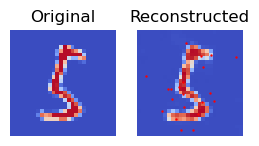

In [15]:
# Reconstruct and log an image, perform inner loop
_, (p, c, g) = inner_loop([enf_params, meta_sgd_params], x_i, y_i, key)

# Reconstruct image
img_reconstructed = enf.apply(enf_params, x_i, p, c, g)[0]

# Plot the original and reconstructed image
plt.figure()
plt.subplot(121)
plt.imshow(jnp.reshape(img[0], (28, 28, 1)), cmap='coolwarm')
plt.title("Original")
plt.axis('off')

# Also plot the latents
plt.subplot(122)
p_norm = (p + 1) / 2 * 28
plt.scatter(p_norm[0, :, 0], p_norm[0, :, 1], color='red', label='Latent', s=0.5)

plt.imshow(jnp.reshape(img_reconstructed, (28, 28, 1)), cmap='coolwarm')
plt.title("Reconstructed")
plt.axis('off')
plt.show()

Looks decent, at least recognizable! Now that we have a backbone that can fit MNIST images in 3 SGD steps, next is using the obtained latents in a downstream task such as classification.

## Downstream classification
Next up is making the choice for our downstream model. To retain equivariance to transformations, the downstream model should also be equivariant. To properly respect the set properties of our latents we should use an equivariant graph neural network, for example [EGNN](https://arxiv.org/abs/2102.09844). For simplicity, we implement a convolutional message passing architecture here that assumes global connectivity of the latent graph, i.e. messages are passed between all latents.

In practice, for best performance we often use [P$\Theta$NITA](https://arxiv.org/abs/2310.02970) as a downstream model with localized message passing operations, but this requires a bit more engineering. An implementation of P$\Theta$NITA for downstream classification can be found on the [reproducibility repo]() of the original ENF paper.

In [16]:
class MessagePassingBlock(nn.Module):
    num_hidden: int
    freq_multiplier: float

    @nn.compact
    def __call__(self, bi_inv, c):
        c = MessagePassing(self.num_hidden, self.freq_multiplier)(bi_inv, c)
        c = nn.Dense(self.num_hidden)(nn.LayerNorm()(c))
        c = nn.Dense(self.num_hidden)(nn.gelu(c))
        return c


class MessagePassing(nn.Module):
    num_hidden: int
    freq_multiplier: float

    def setup(self):
        # Maps from bi-invariants to kernel values, we use an RFF embedding here as well,
        # for the same reasons as mentioned above
        self.kernel_basis = nn.Sequential([
            RFFEmbedding(embedding_dim=self.num_hidden, learnable_coefficients=False, std=self.freq_multiplier),
            nn.Dense(self.num_hidden), nn.gelu, nn.Dense(self.num_hidden), nn.gelu])
        
        # Construct bias
        self.bias_param = self.param('bias', nn.initializers.zeros, (self.num_hidden,))

    def __call__(self, bi_inv, c):
        """ Perform message passing on a fully connected pointcloud.

        Args:
            x: Array of shape (batch, num_points, num_features)
            fiber_kernel_basis: Array of shape (batch, num_points, num_points, basis_dim)
        """
        kernel = self.kernel_basis(bi_inv)

        # Perform the appearance convolution [batch, senders, channels] * [batch, senders, receivers, channels]
        # -> [batch, receivers, channels]
        c = jnp.einsum('bsc,brsc->brc', c, kernel) + self.bias_param
        return c


class EquivMPNN(nn.Module):
    num_hidden: int
    num_layers: int
    num_out: int

    bi_invariant: nn.Module
    freq_multiplier: float

    def setup(self):
        # Initial node embedding
        self.c_stem = nn.Dense(self.num_hidden)

        # Message passing layers
        message_passing_layers = []
        for i in range(self.num_layers):
            message_passing_layers.append(MessagePassingBlock(self.num_hidden, self.freq_multiplier))
        self.message_passing_layers = message_passing_layers

        # Readout
        self.readout_scalar = nn.Sequential([
            nn.Dense(self.num_hidden),
            nn.gelu,
            nn.Dense(self.num_hidden),
            nn.gelu,
            nn.Dense(self.num_out)
        ])

    def __call__(self, p, c):
        """ Forward pass through the network.

        Args:
            p: Poses, array of shape (batch, num_points, spatial_dim)
            c: Context vectors, array of shape (batch, num_points, num_in)
        """
        # Calculate the bi-invariants between the latents themselves.
        bi_inv = self.bi_invariant(p, p)

        # Embed the context vector
        c = self.c_stem(c)

        # Apply interaction layers
        for layer in self.message_passing_layers:
            c = layer(bi_inv, c)

        # Readout layer, average over all nodes in the graph
        out = self.readout_scalar(c.mean(axis=1))
        return out


With this architecture in place, we can now start training for the downstream task! In this setting, we'll use the inner loop we defined above to obtain latents for MNIST images, which we then pass through the MPNN and supervise with the corresponding labels.

In [17]:
key = jax.random.PRNGKey(0)

# Initialize the EMPNN model.
mpnn = EquivMPNN(
    num_hidden=64,
    num_layers=3,
    num_out=10,
    bi_invariant=bi_invariant,
    freq_multiplier=freq_multiplier
)

mpnn_params = mpnn.init(key, p, c)

# Define an optimizer
mpnn_optimizer = optax.adam(learning_rate=1e-4)
mpnn_opt_state = mpnn_optimizer.init(mpnn_params)

# We define a cross entropy loss, for which we want to take the gradient
# this also returns the accuracy.
@jax.jit
def cross_entropy_loss(params, p, c, labels):
    out = nn.log_softmax(mpnn.apply(params, p, c), axis=-1)
    one_hot_labels = jnp.reshape(jax.nn.one_hot(labels, num_classes=10), (-1, 10))
    return -jnp.mean(jnp.sum(one_hot_labels * out, axis=-1)), jnp.mean(jnp.argmax(out, axis=-1) == labels)

# Let's define a train step
@jax.jit
def classifier_train_step(mpnn_params, mpnn_opt_state, enf_params, meta_sgd_params, x_i, y_i, labels, key):
    # Perform an inner loop with the trained ENF to obtain latents z.
    _, (p, c, _) = inner_loop([enf_params, meta_sgd_params], x_i, y_i, key)
    key = jax.random.split(key)[0]
    
    # Take gradients wrt cross-entropy loss
    (loss, acc), grad = jax.value_and_grad(cross_entropy_loss, has_aux=True)(mpnn_params, p, c, labels)

    # Get gradient updates
    mpnn_updates, mpnn_opt_state = mpnn_optimizer.update(grad, mpnn_opt_state)
    mpnn_params = optax.apply_updates(mpnn_params, mpnn_updates)

    return mpnn_params, mpnn_opt_state, key, (loss, acc)

# Training loop
for epoch in range(100):
    epoch_loss = []
    epoch_acc = []
    for i, batch in enumerate(train_loader):
        # Unpack batch, flatten img.
        img, labels = batch
        y_i = jnp.reshape(img, (batch_size, 784, 1))

        mpnn_params, mpnn_opt_state, key, (loss, acc) = classifier_train_step(
            mpnn_params, mpnn_opt_state, enf_params, meta_sgd_params, x_i, y_i, labels, key
        )
        
        # For logging
        epoch_loss.append(loss)
        epoch_acc.append(acc)

    if not epoch % 10:
        print(f"epoch {epoch} -- loss: {sum(epoch_loss) / len(epoch_loss):.2f} acc: {sum(epoch_acc) / len(epoch_acc):.2f}")
print(f"epoch {epoch} -- loss: {sum(epoch_loss) / len(epoch_loss):.2f} acc: {sum(epoch_acc) / len(epoch_acc):.2f}")

epoch 0 -- loss: 2.16 acc: 0.19
epoch 5 -- loss: 1.25 acc: 0.56
epoch 10 -- loss: 0.68 acc: 0.77
epoch 15 -- loss: 0.44 acc: 0.85
epoch 20 -- loss: 0.31 acc: 0.90
epoch 25 -- loss: 0.25 acc: 0.92
epoch 30 -- loss: 0.21 acc: 0.93
epoch 35 -- loss: 0.18 acc: 0.94
epoch 40 -- loss: 0.16 acc: 0.95
epoch 45 -- loss: 0.14 acc: 0.95
epoch 50 -- loss: 0.14 acc: 0.95
epoch 55 -- loss: 0.12 acc: 0.96
epoch 60 -- loss: 0.12 acc: 0.96
epoch 65 -- loss: 0.11 acc: 0.96
epoch 70 -- loss: 0.11 acc: 0.96
epoch 75 -- loss: 0.10 acc: 0.97
epoch 80 -- loss: 0.10 acc: 0.97
epoch 85 -- loss: 0.09 acc: 0.97
epoch 90 -- loss: 0.09 acc: 0.97
epoch 95 -- loss: 0.09 acc: 0.97
epoch 99 -- loss: 0.09 acc: 0.97


Now we will apply the model on the test set. We perform the inner loop to obtain latents from the ENF, and subsequently apply the mpnn to obtain accuracies!

In [18]:
test_acc = []
for i, batch in enumerate(test_loader):
    # Unpack batch, flatten img.
    img,  labels = batch
    y_i = jnp.reshape(img, (batch_size, 784, 1))

    # Perform an inner loop with the trained ENF to obtain latents z. We discard g.
    _, (p, c, _) = inner_loop([enf_params, meta_sgd_params], x_i, y_i, key)

    # Take gradients wrt cross-entropy loss
    _, acc = cross_entropy_loss(mpnn_params, p, c, labels)
    test_acc.append(acc)
print(f"test acc: {sum(test_acc) / len(test_acc):.2f}")

test acc: 0.97


Performance isn't that impressive for MNIST standards, but this is mainly attributable to the shortcuts we took. For a performant ENF and downstream architeture, we kindly refer you to the [ENF](https://github.com/dafidofff/enf) or [ENF-PDE](https://github.com/david-knigge/enf-pde) repos!

## Closing remarks

Although this notebook contains some simplifications here and there, we hope it gave a pretty good idea for how ENFs can be used as signal representations. Of course, all this is a lot of work to get pretty mediocre MNIST classification accuracy, but the power in Neural Fields to us is really in their broad applicability. A lot of the above code can directly be used in segmenting shapes represented with pointclouds or SDFs for example, architecturally you wouldn't have to change a thing.

If you have any questions or comments - or would like to chat about using ENFs in your own work, please don't hesitate to reach out to either of the authors over twitter or email ([David Knigge](https://x.com/davidmknigge) - `d.m.knigge at uva.nl`, [David Wessels](https://x.com/dafidofff) - `d.r.wessels at uva.nl`).

If you're looking for more resources on ENFs:
- [This blogpost]() explains ENFs in more details.
- [This paper](https://davidmknigge.nl/enf-pde-page) uses ENFs for solving PDEs.